# Convolutions

A [convolution](https://en.wikipedia.org/wiki/Convolution) is a linear operator of the form
\begin{equation}
(f \ast g)(t) = \int f(\tau) g(t - \tau ) d\tau
\end{equation}
In a discrete space, this turns into a sum
\begin{equation}
\sum_\tau f(\tau) g(t - \tau)
\end{equation}

Convolutions are *shift invariant*, or *time invariant*.  They frequently appear in temporal and spatial image processing, as well as in probability.

If we want to represent the discrete convolution operator as a matrix, we get a *toeplitz matrix* $G$
\begin{equation}
G = \begin{bmatrix}
g(0) & g(1) & g(2) & \dots\\
g(-1) & g(0) & g(1) &\dots\\
g(-2) & g(-1) & g(0) & \dots\\
\vdots & & &\ddots
\end{bmatrix}
\end{equation}

A circulant matrix on a discrete grid of length $N$ is a toeplitz matrix where $g(-i) = g(N-i)$.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

In [15]:
c = np.arange(0,-4, -1) # first column
r = np.arange(4) # first row
la.toeplitz(c, r)

array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [-2, -1,  0,  1],
       [-3, -2, -1,  0]])

In [13]:
c = np.arange(4)
la.circulant(c)

array([[0, 3, 2, 1],
       [1, 0, 3, 2],
       [2, 1, 0, 3],
       [3, 2, 1, 0]])

both toeplitz and circulant matrices have special `solve` function in `scipy.linalg`

In [24]:
N = 100
c = np.random.randn(N)
r = np.random.randn(N)
A = la.toeplitz(c, r)

x = np.random.rand(N)

print("standard solve")
%time y1 = la.solve(A, x)

print("\ntoeplitz solve")
%time y2 = la.solve_toeplitz((c,r), x)

print(la.norm(y1- y2))

standard solve
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 826 µs

toeplitz solve
CPU times: user 234 µs, sys: 0 ns, total: 234 µs
Wall time: 193 µs
6.159157357270676e-12


In [29]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)

print("standard solve")
%time y1 = la.solve(A, x)

print("\ncirculant solve")
%time y2 = la.solve_circulant(c, x)

print(la.norm(y1- y2))

standard solve
CPU times: user 1.76 ms, sys: 48 µs, total: 1.81 ms
Wall time: 985 µs

circulant solve
CPU times: user 213 µs, sys: 0 ns, total: 213 µs
Wall time: 201 µs
3.8506968586483955e-15


### Example

One place where convolutions appear is in combining probability distributions.  For instance, if we take a sample $x \sim y + z$ where $y \sim f$ and $z \sim g$ and $f, g$ are probability density functions, then the probability density function that describes the random variable $x$ is $f\ast g$.

## Fourier Transforms

A [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) takes functions back and forth between time and frequency domains.
\begin{equation}
\hat{f}(\omega) = \int_{-\infty}^\infty f(x) e^{-2\pi i x \omega} dx
\end{equation}

In practice, Fourier transforms are often computed using the Fast Fourier Transform (FFT) algorithm, which runs in $O(N\log N)$ time for a signal of length $N$.  Scipy provides funcitons for FFT as well as the inverse iFFT.


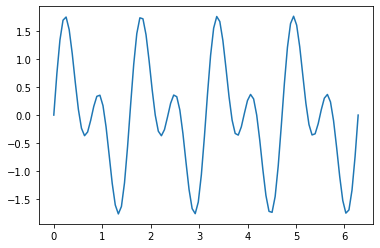

In [40]:
from scipy.fft import fft, ifft

x = np.linspace(0, 2*np.pi, 100)
f = np.sin(4*x) + np.sin(8*x)
plt.plot(x, f)

the function in frequency space typically has real and imaginary components.

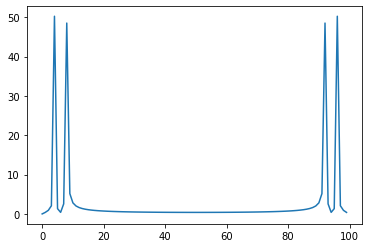

In [43]:
fhat = fft(f)
plt.plot(np.abs(fhat))
plt.show()

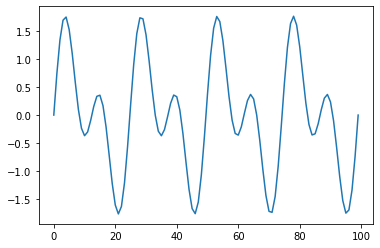

In [45]:
f2 = ifft(fhat)
plt.plot(np.real(f2))
plt.show()

Fourier transforms can reveal a variety of useful information and have many useful properties.  One of which is that convolutions in the time/spatial domain become pointwise multiplication in the frequency domain.

\begin{equation}
h = f \ast g \Leftrightarrow \hat{h} = \hat{f} \hat{g}
\end{equation}

This means that circulant matrices and their inverses can be applied in $O(N \log N)$ time using the FFT.

In [46]:
def apply_circulant(c, x):
    """
    apply circulant matrix with first row c to a vector x
    
    y = C x
    """
    c_hat = fft(c)
    x_hat = fft(x)
    y_hat = c_hat * x_hat
    return ifft(y_hat)

In [48]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)

%time y1 = A @ x
%time y2 = apply_circulant(c, x)

la.norm(y1 - y2)

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 43.9 µs
CPU times: user 434 µs, sys: 0 ns, total: 434 µs
Wall time: 383 µs


3.158782819493711e-14

In [49]:
def apply_circulant_inv(c, x):
    """
    apply inverse of circulant matrix with first row c to a vector x
    
    y = C^{-1} x
    """
    c_hat = fft(c)
    x_hat = fft(x)
    y_hat = x_hat / c_hat
    return ifft(y_hat)

In [50]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)
b = A @ x

%time y1 = la.solve_circulant(c, x)
%time y2 = apply_circulant_inv(c, x)

la.norm(y1 - y2)

CPU times: user 242 µs, sys: 15 µs, total: 257 µs
Wall time: 233 µs
CPU times: user 269 µs, sys: 0 ns, total: 269 µs
Wall time: 255 µs


4.5836491643602516e-15

### Exercise

Create a plot that demonstrates the asymptotic scaling of the FFT is $O(N \log N)$

In [ ]:
## Your code here

## Higher Dimensions

In 2 dimensions, you can use scipy's [`fft2` and `ifft2`](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#and-n-d-discrete-fourier-transforms) for 2-dimensional signals such as images.

### Sparse Convolutions

In image processing, you may often encounter sparse convolutions, particularly convolutions that are very localized (e.g. only the first few entries of the firs row `c` are nonzero).  One example is that many camera lenses cause a slight blur which mixes light from nearby sources.  In deep learning, these sparse convolutions have been very effective in image processing tasks. Perhaps the simplest explanation of why learning parameters for a convolution is a good idea in this situation is that convolutions are *translation invariant* allowing the neural net to learn regardless of where a target appears on an image.

In this case, we typically think of convolutions as $k\times k$ patches which slide over a 2-dimensional image.  